In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

**DATA LOADING & EXPLORATION**

In [4]:
df = pd.read_csv('bitcoin.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
df.shape

(2713, 7)

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 148.5+ KB


**EDA**

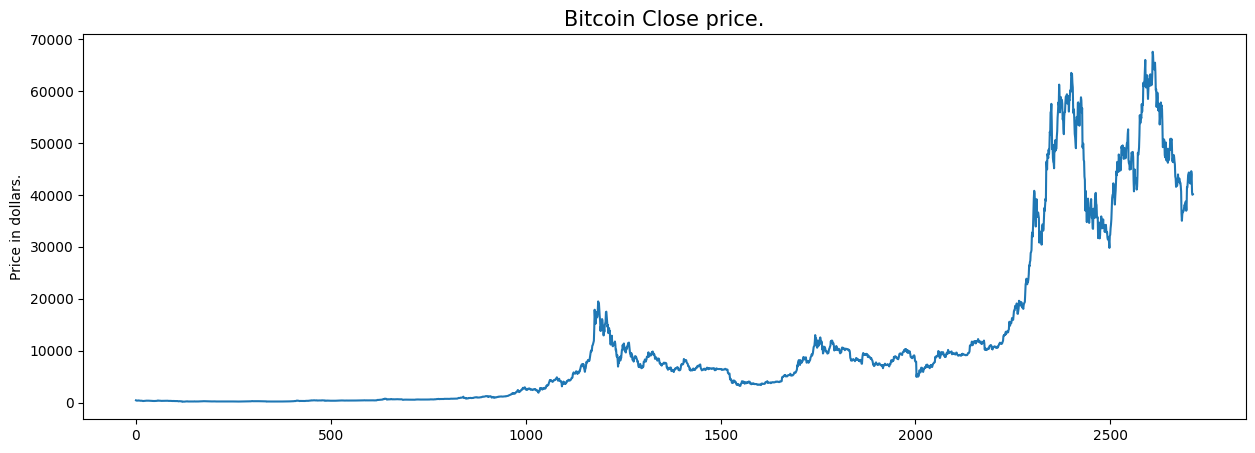

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [9]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((2713, 7), (2713, 7))

In [10]:
df = df.drop(['Adj Close'], axis=1)

In [11]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


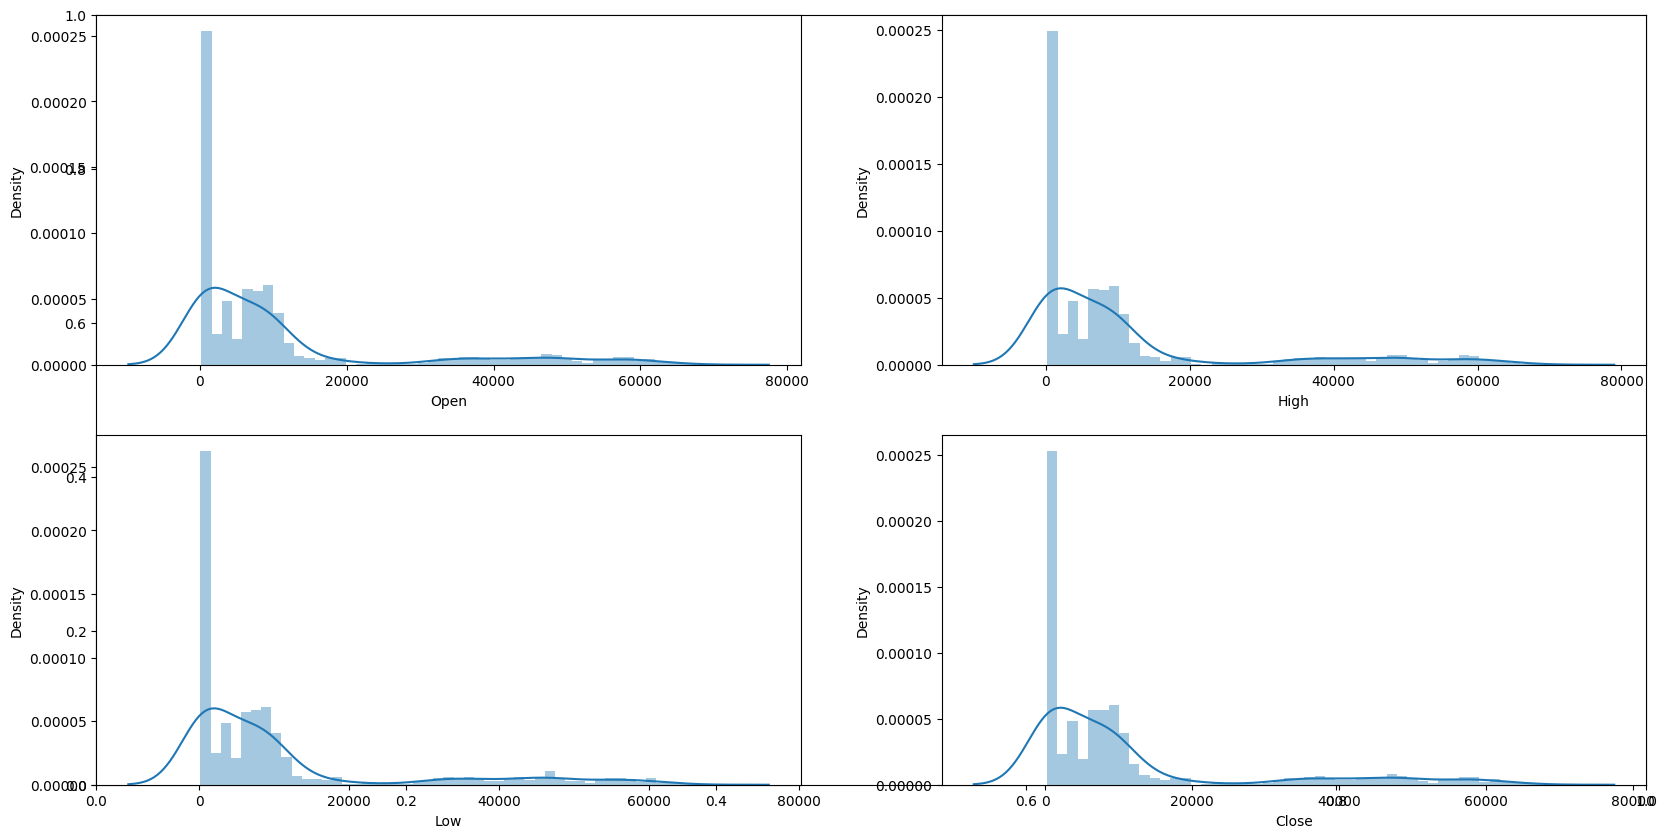

In [13]:
import seaborn as sb
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.distplot(df[col])
plt.show()

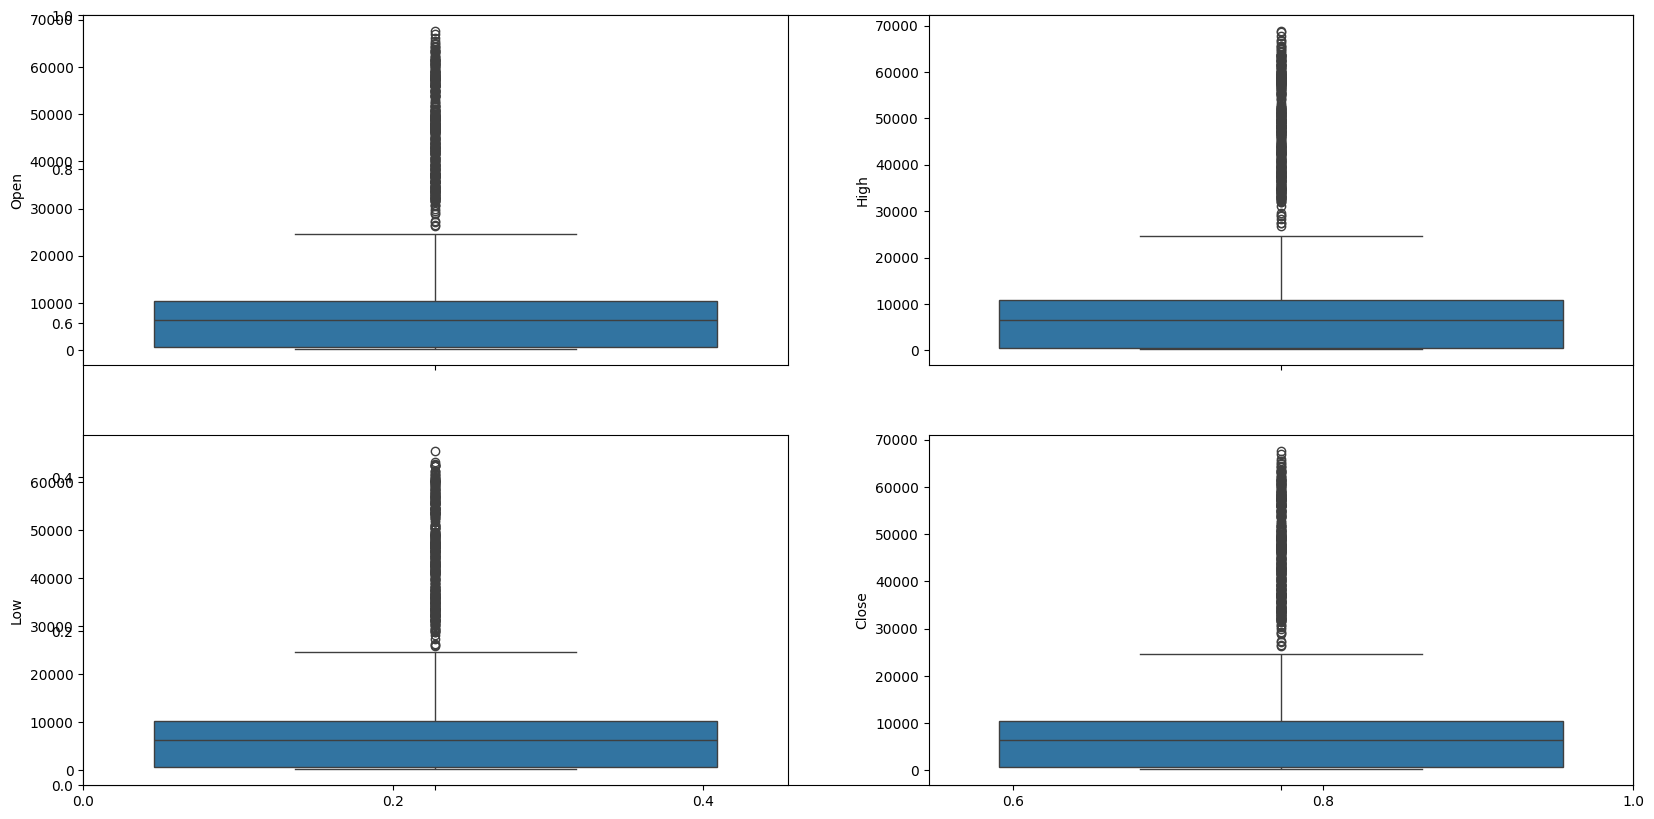

In [14]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.boxplot(df[col])
plt.show()

**DATA NORMALIZATION & STANDARDIZATION**

In [47]:
# Selecting numerical features for normalization and standardization
numerical_features = ['Open', 'High', 'Low', 'Close', 'Volume']
categorical_features = ['is_quarter_end']  # Modify if more categorical features exist

In [48]:
# Standardization (StandardScaler)
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [49]:
# Encoding categorical features (One-Hot Encoding)
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

In [50]:
# Save processed dataset
df.to_csv("bitcoin_preprocessed.csv", index=False)

print("Data normalization and standardization completed successfully!")

Data normalization and standardization completed successfully!


**FEATURE SELECTION**

In [51]:
# Drop irrelevant columns
df.drop(columns=['year', 'Close'], errors='ignore', inplace=True)

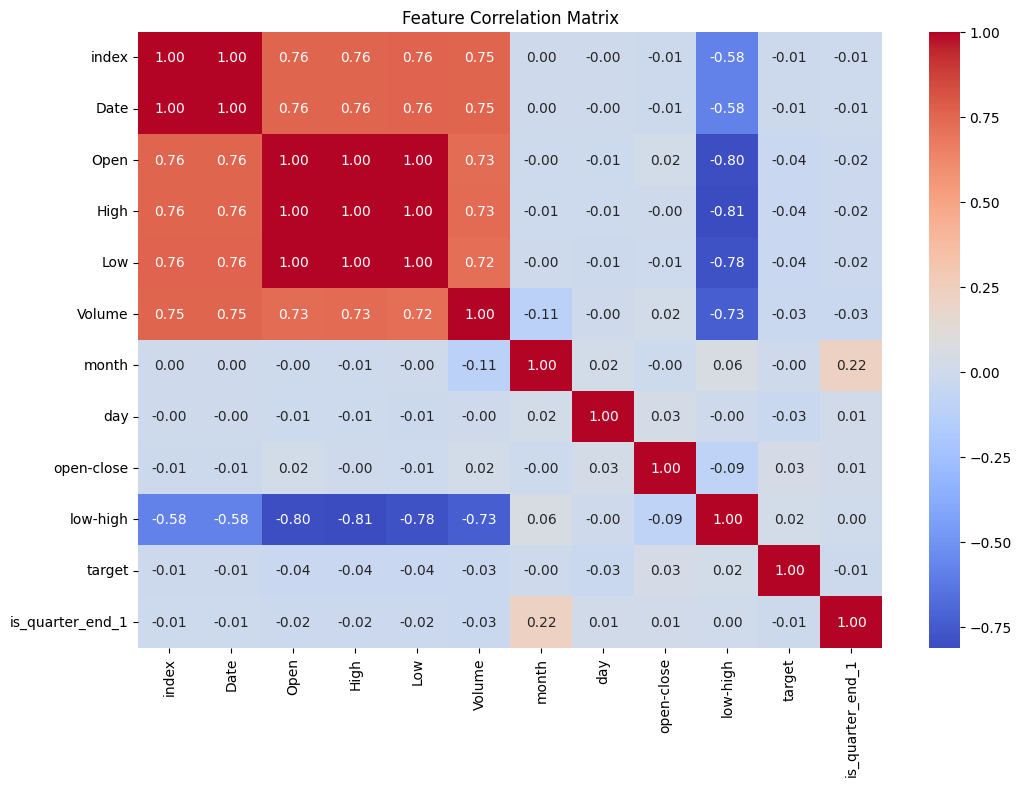

In [52]:
# Correlation Matrix - Identify highly correlated features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [53]:
# Dropping highly correlated features (Threshold > 0.85)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.85)]
df.drop(columns=high_corr_features, inplace=True)

print(f"Removed highly correlated features: {high_corr_features}")

Removed highly correlated features: ['Date', 'High', 'Low']


In [54]:
# Feature & Target Split
features = df.drop(columns=['target'], errors='ignore')
target = df['target']

In [55]:
# Standardize Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [56]:
# Recursive Feature Elimination (RFE) with Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(model, n_features_to_select=5)  # Select top 5 features
rfe.fit(features_scaled, target)

RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=5)

In [57]:
# Selected Features
selected_features = features.columns[rfe.support_]
print(f"Top selected features from RFE: {list(selected_features)}")

Top selected features from RFE: ['index', 'Open', 'Volume', 'open-close', 'low-high']


In [58]:
# Feature Importance using Random Forest
# Top 5 Important Features
model.fit(features_scaled, target)
feature_importance = pd.Series(model.feature_importances_, index=features.columns)
top_features = feature_importance.nlargest(5)

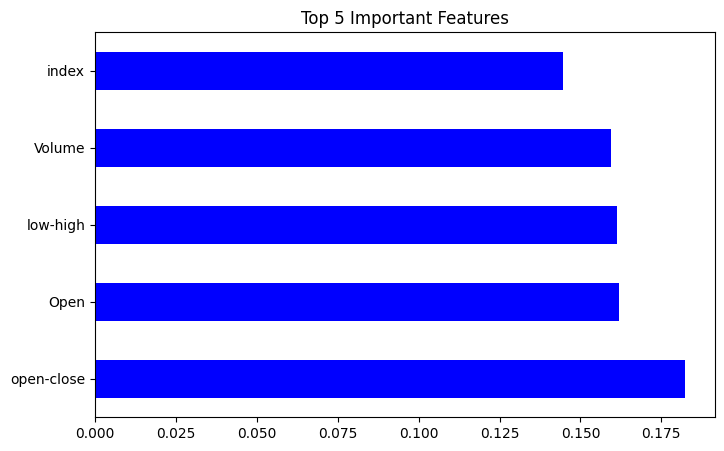

In [59]:
# Plot Feature Importance
plt.figure(figsize=(8, 5))
top_features.plot(kind='barh', color='blue')
plt.title("Top 5 Important Features")
plt.show()

In [60]:
# Save the final selected dataset
df = df[list(selected_features) + ['target']]
df.to_csv("bitcoin_selected_features.csv", index=False)

print("Feature selection completed successfully!")

Feature selection completed successfully!


**FEATURE ENGINEERING**

In [15]:
splitted = df['Date'].str.split('-', expand=True)

df['year'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['day'] = splitted[2].astype('int')

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


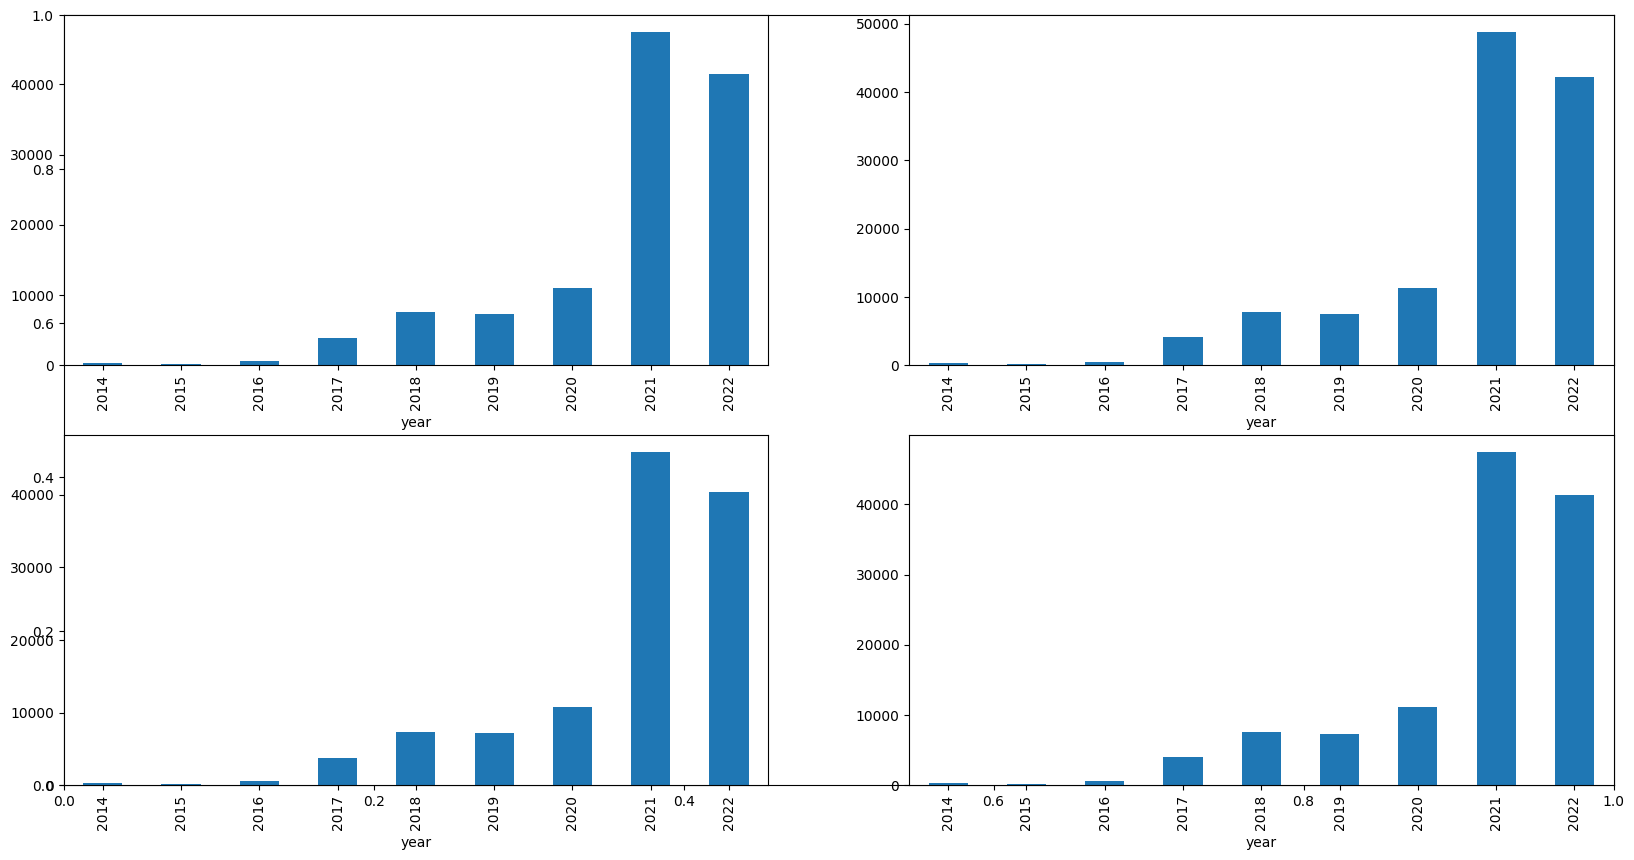

In [16]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [17]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1


In [18]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

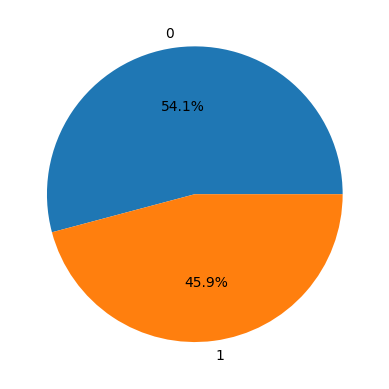

In [19]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

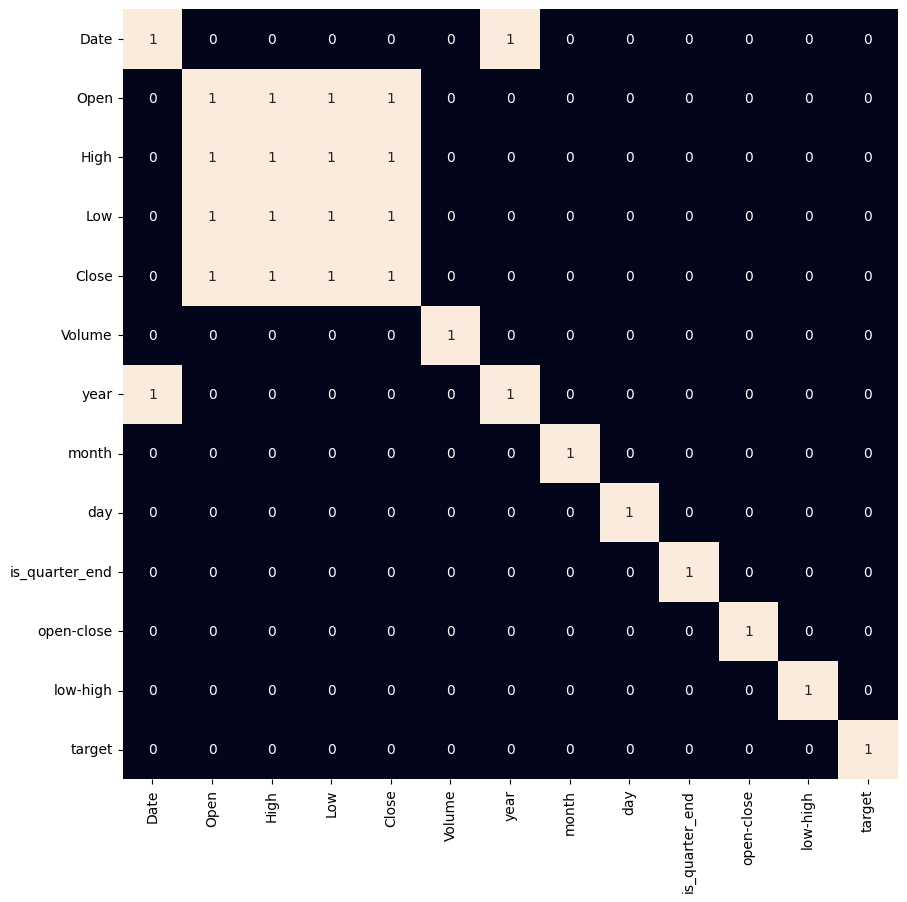

In [20]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [43]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
#We do not use train test split, rather use the first 70% data to train and last 30% to test
X_train, X_valid, Y_train, Y_valid = X_train, X_valid, Y_train, Y_valid = features[:len(features)//7],features[len(features)//7:],target[:len(features)//7],target[len(features)//7:]

**MODEL DEVELOPMENT AND EVALUATION**

In [45]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5351397573619796
Validation Accuracy :  0.5170956321701721

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4734915290470846
Validation Accuracy :  0.4910936753107074

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training 

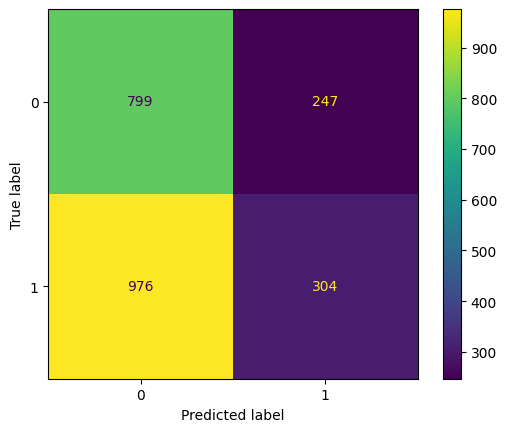

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()